In [129]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import re
np.random.seed(5)

from sklearn.metrics import log_loss, classification_report

# for ploting graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to create word clouds
from wordcloud import WordCloud, STOPWORDS 

# Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer

In [130]:
# for deep learning
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [148]:
df =  pd.read_csv('df_tratado.csv')
df['data'] = pd.to_datetime(df['data'], format="%Y-%m-%d")
df.head()

,controle_review_longo,data,nota,Notas
0,Que sensacional! O modelo da minha tv é uma da...,2021-05-10,5,Positivo
1,Devo dizer que estou bem decepcionado.\nCompre...,2021-07-13,2,Negativo
2,Eu comprei esse modelo justamente pelos botões...,2021-05-15,3,Positivo
3,"Pow, Amazon, que isso? vcs eram tão competente...",2021-09-27,1,Negativo
4,Pontos positivos: o processo de instalação é b...,2021-05-17,5,Positivo


In [149]:
df.dtypes

controle_review_longo            object
data                     datetime64[ns]
nota                              int64
Notas                            object
dtype: object

In [167]:
df_data =  pd.read_csv('df_data.csv')
df_data['mes_ano'] = pd.to_datetime(df_data['mes_ano'], format="%Y-%m")
df_data.head(20)

,mes_ano,positivo,negativo
0,2021-05-01,112,3
1,2021-06-01,86,5
2,2021-07-01,67,17
3,2021-08-01,61,8
4,2021-09-01,99,10
5,2021-10-01,108,6
6,2021-11-01,135,15
7,2021-12-01,354,26
8,2022-01-01,188,18
9,2022-02-01,140,16


In [168]:
import plotly.graph_objects as go
# Definindo o Gráfico
y = df_data['positivo']

y1 = df_data['negativo']
x =x1 = df_data['mes_ano']

fig_data = go.Figure()
fig_data.add_trace(go.Scatter(x=x, y=y, name = 'Reviews Positivos'))
fig_data.add_trace(go.Scatter(x=x1, y=y1, name = 'Reviews Negativos'))
fig_data.update_layout(xaxis_title='Período',
yaxis_title='Quantidade de Reviews', 
template = 'plotly_white') #adicionando o template
fig_data.show()

In [169]:
df_data.dtypes

mes_ano     datetime64[ns]
positivo             int64
negativo             int64
dtype: object

#  Análises

Preprarando os dados de reviews

In [170]:
from sklearn import preprocessing
# Convertendo as avaliações
def converteCategoria(df, coluna):
    le = preprocessing.LabelEncoder()
    le.fit(df[coluna])
    df[coluna] = le.transform(df[coluna])
    return le

labelEncoderNotas = converteCategoria(df, 'Notas')
df.head()

,controle_review_longo,data,nota,Notas
0,Que sensacional! O modelo da minha tv é uma da...,2021-05-10,5,1
1,Devo dizer que estou bem decepcionado.\nCompre...,2021-07-13,2,0
2,Eu comprei esse modelo justamente pelos botões...,2021-05-15,3,1
3,"Pow, Amazon, que isso? vcs eram tão competente...",2021-09-27,1,0
4,Pontos positivos: o processo de instalação é b...,2021-05-17,5,1


Palavras mais frequentes

In [171]:
# Definindo contador de palavras
def plot_ngram(nota, n):
    
    temp_df = df[df['Notas'] == nota]
    
    word_vectorizer = CountVectorizer(ngram_range=(n, n), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(temp_df['controle_review_longo'])
    
    frequencies = sum(sparse_matrix).toarray()[0]
    
    return pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])\
            .sort_values(by='frequency', ascending=False) \
            .reset_index() \
            .head(10)

In [172]:
# Palavras mais frequentes dos reviews positivos
plot_ngram(1, 1)

,index,frequency
0,de,2502
1,que,1911
2,não,1611
3,tv,1539
4,com,1300
5,muito,1087
6,para,955
7,da,907
8,do,871
9,um,775


In [173]:
# Palavras mais frequentes dos reviews negativos
plot_ngram(0, 1)

,index,frequency
0,de,264
1,não,254
2,que,194
3,com,127
4,tv,116
5,para,103
6,um,93
7,da,92
8,do,83
9,mas,77


Palavras mais fequentes usando StopWords e WordCloud

In [174]:
# Definindo as StopWords
stopwords  = ['de', 'a', 'o','que','e','do','da', 'em','um', 'para', 'é', 'com', 'uma', 
            'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 
            'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 
            'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 
            'entre', 'era','depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 
            'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 
            'meu', 'às', 'minha', 'têm','numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 
            'nós', 'tenho','lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 
            'te', 'vocês', 'vos', 'lhes', 'meus','minhas','teu', 'tua','teus','tuas','nosso', 'nossa',
            'nossos','nossas','dela','delas','esta' ,"estes ","estas ",'aquele',"aquela", "aqueles", 
            "aquelas","isto","aquilo" ,"estou","está","estamos","estão","estive","esteve","estivemos",
            "estiveram","estava","estávamos","estavam","estivera","estivéramos","esteja","estejamos",
            "estejam","estivesse","estivéssemos","estivessem","estiver","estivermos","estiverem",
            "hei","há","havemos","hão","houve","houvemos","houveram","houvera","houvéramos","haja",
            "hajamos","hajam","houvesse","houvéssemos","houvessem","houver",'houvermos','houverem',
            'houverei','houverá','houveremos','houverão','houveria','houveríamos','houveriam','sou',
            'somos','são','era','éramos','eram','fui','foi','fomos','foram','fora','fôramos','seja',
            'sejamos','sejam','fosse','fôssemos','fossem','for','formos','forem','serei','será',
            'seremos','serão','seria','seríamos','seriam','tenho','tem','temos','tém','tinha','tínhamos',
            'tinham','tive','teve','tivemos','tiveram','tivera','tivéramos','tenha','tenhamos','tenham',
            'tivesse','tivéssemos','tivessem','tiver','tivermos','tiverem','terei','terá','teremos',
            'terão','teria','teríamos','teriam']

In [175]:
# Definindo função das nuvens de palavras
def plot_wordcloud(review, cmap):
    fig, ax = plt.subplots(figsize=(8, 6))
    wc = WordCloud(max_words = 1000, background_color ='white', stopwords = stopwords, 
                   min_font_size = 10, colormap=cmap)
    wc = wc.generate(review)
    plt.axis('off')
    plt.imshow(wc)

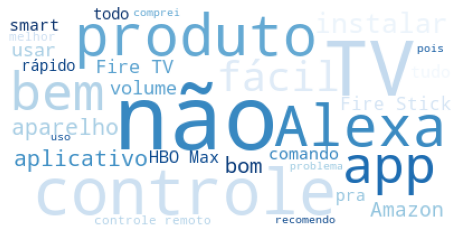

In [176]:
# word cloud nos reviews positivos
pos_rev = ' '.join(df[df['Notas']==1]['controle_review_longo'].to_list()[:10000])
plot_wordcloud(pos_rev, 'Blues')

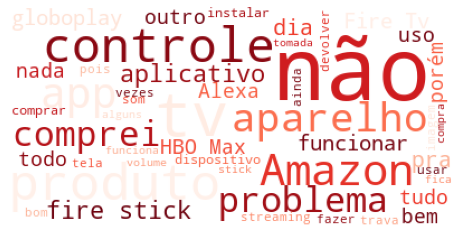

In [177]:
# word cloud nos reviews negativos
neg_rev = ' '.join(df[df['Notas']==0]['controle_review_longo'].to_list()[:10000])
fig2 = plot_wordcloud(neg_rev, 'Reds')
fig2

# Processando os dados

In [178]:
# to remove the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# to remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [179]:
# Processando os reviews
df['controle_review_longo'] = df['controle_review_longo'].apply(remove_URL)
df['controle_review_longo'] = df['controle_review_longo'].apply(remove_html)
df['controle_review_longo'] = df['controle_review_longo'].str.lower()

df['controle_review_longo'] = df['controle_review_longo'].apply(remove_stopwords)

df.head()

,controle_review_longo,data,nota,Notas
0,sensacional! modelo tv primeiras smarts imagem...,2021-05-10,5,1
1,devo dizer bem decepcionado. comprei produto f...,2021-07-13,2,0
2,comprei modelo justamente botões volume power ...,2021-05-15,3,1
3,"pow, amazon, isso? vcs tão competentes coma en...",2021-09-27,1,0
4,pontos positivos: processo instalação bem orie...,2021-05-17,5,1


# Random Forest

In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

vectorizer = CountVectorizer(stop_words=stopwords)
alexa_countvectorizer = vectorizer.fit_transform(df['controle_review_longo'])
alexa_countvectorizer.shape

(1510, 5741)

In [183]:
# Separando dados em traino e teste
X = alexa_countvectorizer
y = np.array([label for label in df['Notas']])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, stratify=y)

print("X_train Size :",X_train.shape)
print("X_test Size :",X_test.shape)
print("y_train Size :",y_train.shape)
print("y_test Size :",y_test.shape)

seed = 42

X_train Size : (1208, 5741)
X_test Size : (302, 5741)
y_train Size : (1208,)
y_test Size : (302,)



Random Forest usando RandomizedSearchCV


In [184]:
from scipy import stats
from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

In [185]:
# Instanciando o modelo
rfc = RandomForestClassifier(random_state=seed)

# K-fold estratificado com k = 10
cv = model_selection.StratifiedKFold(n_splits=10)

# definição dos parâmetros para a árvore de decisão
param_distributions = { 
                        'n_estimators': [100,200,300,400],
                        'criterion': ['gini', 'entropy'],
                        'max_depth': [6,7,8,9,10],
                        'min_samples_split': [7,8,9,10,12,15],
                        'min_samples_leaf': [3,4,5,6,7,8,9,10],
                        'max_features':['auto', 'sqrt', 'log2']
                      }

# define random search for decision tree
rnd_search_rfc = RandomizedSearchCV(  estimator=rfc, 
                                      param_distributions = param_distributions, 
                                      n_iter=25, scoring='accuracy', 
                                      n_jobs=-1, cv=cv, random_state=seed
                                    )
# execute search
result_rfc = rnd_search_rfc.fit(X_train, y_train)

# summarize result for random forest
print('=========Random Search Results for RandomForest==========')
print('Best Score: %s' % result_rfc.best_score_)
print('Best Hyperparameters: %s' % result_rfc.best_params_)

# Instanciando e avaliando o modelo
RFC = RandomForestClassifier(**result_rfc.best_params_, random_state=seed)

model = RFC.fit(X_train, y_train)
y_predicted = RFC.predict(X_test)

print('\nDesempenho médio do RandomForest:')

cv_results = model_selection.cross_val_score(RFC, X_train, y_train, cv=cv, scoring='accuracy')

name = 'RandomForest'
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

print("\nAcuracia do Random Forest: Treinamento",  RFC.score(X_train, y_train)," Teste", RFC.score(X_test, y_test))
print("\nClasification report:\n", classification_report(y_test, y_predicted))

=========Random Search Results for RandomForest==========
Best Score: 0.912258953168044
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'gini'}

Desempenho médio do RandomForest:
RandomForest: 0.912259 (0.003886)

Acuracia do Random Forest: Treinamento 0.9122516556291391  Teste 0.9139072847682119

Clasification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.91      1.00      0.96       276

    accuracy                           0.91       302
   macro avg       0.46      0.50      0.48       302
weighted avg       0.84      0.91      0.87       302



In [63]:
resultados =[]
modelos = []
modelos.append('Random Forest desempenho médio')
resultados.append(RFC.score(X_test, y_test))
print('resultados' ,resultados)
print('Modelos' ,modelos)

resultados [0.9139072847682119]
Modelos ['Random Forest desempenho médio']


# Redes Neurais

Reviews e Avaliações

In [64]:
# container for sentences
reviews = np.array([review for review in df['controle_review_longo']])

# container for labels
labels = np.array([label for label in df['Notas']])

Separando dados em treino e teste

In [65]:
# Usando train-test split
from sklearn.model_selection import train_test_split

train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(reviews, labels, 
                                                                                test_size=0.20, 
                                                                                stratify=labels)

Toquenizando os reviews

In [66]:
max_length = 220
vocab_size = 10000
embedding_dim = 100    
print(max_length)

220


In [67]:
# Toquenizando as sentenças
tokenizer = Tokenizer(num_words = vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', oov_token="<OOV>")
tokenizer.fit_on_texts(df['controle_review_longo'].values)
word_index = tokenizer.word_index
print('Quantidade total de palavras toquenizadas:',len(word_index))

# Convertendo o conjunto de treinamendo e adicionando o padding
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# Convertendo o conjunto de validação e adicionando o padding
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding='post', maxlen=max_length)


Quantidade total de palavras toquenizadas: 5930


In [68]:
train_padded.shape

(1208, 220)

In [69]:
validation_padded.shape

(302, 220)

# Definindo a função de plot da accuracy e loss

In [70]:
def plot_history_acc(history):
    import plotly.graph_objects as go
    
    # Definindo o Gráfico
    y = history.history['accuracy']
    y1 = history.history['val_accuracy']
    x =x1 = [1,2,3,4,5,6,7,8,9,10]

    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=x, y=y, name = 'Training Accuracy'))
    fig1.add_trace(go.Scatter(x=x1, y=y1, name = 'Validation Accuracy'))
    fig1.update_layout(xaxis_title='Épocas',
    yaxis_title='Acurácia', 
    template = 'plotly_white') #adicionando o template
    
    return fig1
       
def plot_history_loss(history):
    import plotly.graph_objects as go
    
    # Definindo o Gráfico
    y = history.history['loss']
    y1 = history.history['val_loss']
    x =x1 = [1,2,3,4,5,6,7,8,9,10]

    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=x, y=y, name = 'Training Loss'))
    fig2.add_trace(go.Scatter(x=x1, y=y1, name = 'Validation Loss'))
    fig2.update_layout(xaxis_title='Épocas',
    yaxis_title='Loss', 
    template = 'plotly_white') #adicionando o template
    
    return fig2  

# Modelo LSTM 

In [71]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 220, 100)          1000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                3096      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,087,601
Trainable params: 1,087,601
Non-trainable params: 0
____________________________________________

In [72]:
from keras.callbacks import EarlyStopping

# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.001)])

# predict values
pred = model.predict(validation_padded)

Epoch 1/10
34/34 - 7s - loss: 0.4571 - accuracy: 0.8933 - val_loss: 0.2629 - val_accuracy: 0.9339 - 7s/epoch - 214ms/step
Epoch 2/10
34/34 - 4s - loss: 0.3148 - accuracy: 0.9098 - val_loss: 0.2379 - val_accuracy: 0.9339 - 4s/epoch - 125ms/step
Epoch 3/10
34/34 - 4s - loss: 0.2422 - accuracy: 0.9108 - val_loss: 0.2093 - val_accuracy: 0.9339 - 4s/epoch - 126ms/step
Epoch 4/10
34/34 - 4s - loss: 0.1320 - accuracy: 0.9494 - val_loss: 0.1947 - val_accuracy: 0.9421 - 4s/epoch - 129ms/step
Epoch 5/10
34/34 - 4s - loss: 0.0484 - accuracy: 0.9926 - val_loss: 0.3252 - val_accuracy: 0.9339 - 4s/epoch - 125ms/step
Epoch 6/10
34/34 - 4s - loss: 0.0249 - accuracy: 0.9926 - val_loss: 0.2899 - val_accuracy: 0.9339 - 4s/epoch - 122ms/step
Epoch 7/10
34/34 - 4s - loss: 0.0099 - accuracy: 0.9991 - val_loss: 0.4799 - val_accuracy: 0.9256 - 4s/epoch - 122ms/step


In [73]:
# Plotando os resultados da acurácia
fig1=plot_history_acc(history)
fig1.show()

In [74]:
# Plotando os resultados da loss
fig2 = plot_history_loss(history)
fig2.show()

In [75]:
modelos.append('LSTM_validation_acc')
modelos.append('LSTM_validation_loss')
resultados.append(0.9173)
resultados.append(0.1988)
print('resultados' ,resultados)
print('Modelos' ,modelos)

resultados [0.9139072847682119, 0.9173, 0.1988]
Modelos ['Random Forest desempenho médio', 'LSTM_validation_acc', 'LSTM_validation_loss']


In [34]:
plotly_fig = mpl_to_plotly(fig1)
graph = dcc.Graph(id='myGraph', fig=plotly_fig)

NameError: name 'mpl_to_plotly' is not defined

# Modelo CNN

In [76]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 220, 100)          1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 24)                3096      
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                      

In [77]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.001)])

# predict values
pred = model.predict(validation_padded)

Epoch 1/10
34/34 - 2s - loss: 0.4961 - accuracy: 0.8519 - val_loss: 0.2413 - val_accuracy: 0.9339 - 2s/epoch - 45ms/step
Epoch 2/10
34/34 - 1s - loss: 0.3326 - accuracy: 0.9089 - val_loss: 0.2427 - val_accuracy: 0.9339 - 948ms/epoch - 28ms/step
Epoch 3/10
34/34 - 1s - loss: 0.3091 - accuracy: 0.9098 - val_loss: 0.2411 - val_accuracy: 0.9339 - 939ms/epoch - 28ms/step
Epoch 4/10
34/34 - 1s - loss: 0.2731 - accuracy: 0.9098 - val_loss: 0.2180 - val_accuracy: 0.9339 - 943ms/epoch - 28ms/step
Epoch 5/10
34/34 - 1s - loss: 0.1874 - accuracy: 0.9181 - val_loss: 0.1915 - val_accuracy: 0.9339 - 937ms/epoch - 28ms/step
Epoch 6/10
34/34 - 1s - loss: 0.0940 - accuracy: 0.9595 - val_loss: 0.1833 - val_accuracy: 0.9339 - 947ms/epoch - 28ms/step
Epoch 7/10
34/34 - 1s - loss: 0.0507 - accuracy: 0.9853 - val_loss: 0.2246 - val_accuracy: 0.9339 - 925ms/epoch - 27ms/step
Epoch 8/10
34/34 - 1s - loss: 0.0208 - accuracy: 0.9991 - val_loss: 0.2523 - val_accuracy: 0.9339 - 957ms/epoch - 28ms/step
Epoch 9/10


In [78]:
# Plotando acurácia
fig3 = plot_history_acc(history)
fig3.show()

In [79]:
# Plotando loss
fig4 = plot_history_loss(history)
fig4.show()

In [80]:
modelos.append('CNN_validation_acc')
modelos.append('CNN_validation_loss')
resultados.append(0.9421)
resultados.append(0.1854)
print('resultados' ,resultados)
print('Modelos' ,modelos)

resultados [0.9139072847682119, 0.9173, 0.1988, 0.9421, 0.1854]
Modelos ['Random Forest desempenho médio', 'LSTM_validation_acc', 'LSTM_validation_loss', 'CNN_validation_acc', 'CNN_validation_loss']


In [81]:
novo = pd.DataFrame(list(zip(modelos, resultados)), columns=["Modelo", "Acurácia"]).sort_values(by= "Modelo",ascending=True)

import plotly
import plotly.express as px
import plotly.graph_objects as go

fig = px.bar(novo, x = 'Acurácia', y = 'Modelo', text_auto=True,
             labels={'Acurácia': 'Acurácia', 'Modelo': 'Modelos', 'variable':' Disciplina'},
            color_discrete_sequence=px.colors.qualitative.T10, template = 'plotly_white')
fig.update_layout(title={'text' : 'Comparando o desempenho entre os modelos', 'y': 0.95, 'x': 0.45})
fig.show()

In [82]:
import dash
from dash import dcc
from dash import html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

In [108]:
# Criando o dashboard
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.SANDSTONE],
                meta_tags=[{'name': 'viewport',
                            'content': 'width=device-width, initial-scale=1.0'}]
                )

app.layout = dbc.Container([
    
    dbc.Row(
        dbc.Col(html.H1("ANÁLISE DE SENTIMENTO DE REVIEWS DO FIRE TV STICK",
                        className='text-center text-primary mb-4'),
                width=12)
    ), 
    
    dbc.Row([
        dbc.Col([
            html.H1("Resultados usando LSTM e CNN"),
            dcc.Dropdown(
                id= 'dropdown1',
                options= [
                    {'label' : 'Desempenho dos modelos', 'value' : 'Desempenho'},
                    {'label' : 'LSTM_acc', 'value' : 'LSTM_acc'},
                    {'label' : 'LSTM_loss', 'value' : 'LSTM_loss'},
                    {'label' : 'CNN_acc', 'value' : 'CNN_acc'},
                    {'label' : 'CNN_loss', 'value' : 'CNN_loss'}
                ],
                value='Desempenho'
            ),     
            dcc.Graph(id="choropleth-map1", figure= fig
            )       
        ]),
        
        dbc.Col([
            html.H1("Resultados dos modelos"),
            dcc.Dropdown(
                id= 'dropdown2',
                options= [
                    {'label' : 'Desempenho dos modelos ', 'value' : 'Desempenho_st'},
                    {'label' : 'LSTM acc steaming', 'value' : 'LSTM_acc_st'},
                    {'label' : 'LSTM loss steaming', 'value' : 'LSTM_loss_st'},
                    {'label' : 'CNN acc steaming', 'value' : 'CNN_acc_st'},
                    {'label' : 'CNN loss steaming', 'value' : 'CNN_loss_st'}
                ],
                value='Desempenho_st'
            ),     
            dcc.Graph(id="choropleth-map2", figure= fig
            )       
        ])
    ]),
        
], fluid=True)


@app.callback(
    Output(component_id='choropleth-map1', component_property='figure'),
    Input(component_id='dropdown1', component_property='value')
)
def changeText(value):
    if value == 'Desempenho':
        return fig
    elif value == 'LSTM_acc':
        return fig1
    elif value == 'LSTM_loss':
        return fig2
    elif value == 'CNN_acc':
        return fig3
    else:
        return fig4

@app.callback(
    Output(component_id='choropleth-map2', component_property='figure'),
    Input(component_id='dropdown2', component_property='value')
)
def changeText(value):
    if value == 'Desempenho_st':
        return fig
    elif value == 'LSTM_acc_st':
        return fig1
    elif value == 'LSTM_loss_st':
        return fig2
    elif value == 'CNN_acc_st':
        return fig3
    else:
        return fig4

    
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

 * Running on http://127.0.0.1:8050 (Press CTRL+C to quit)
127.0.0.1 - - [04/Apr/2022 01:03:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2022 01:03:19] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2022 01:03:19] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2022 01:03:19] "GET /_favicon.ico?v=2.3.1 HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2022 01:03:19] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [04/Apr/2022 01:03:19] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [04/Apr/2022 01:03:19] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [04/Apr/2022 01:03:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2022 01:03:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2022 01:03:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Apr/2022 01:03:32] "POST /_dash-update-component HTTP/1.1" 2

# A partir daqui só têm análises de testes
Possivelmente serão excluídas.
Estão aqui só para verificar algumas possibilidades.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Codificando o texto em linguagem natural

In [ ]:
# Toquenização
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

tokenized_sents = [word_tokenize(i) for i in df['controle_review_longo'].values]

# Representação de palavras usando o Word2Vec
from gensim.models import Word2Vec
model_review = Word2Vec(tokenized_sents, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Separando dados de entrado e de saída (labels)
X, y = [], []
max_len = 0

for i, row in df.iterrows():
    vetores = model_review.wv[word_tokenize(row['controle_review_longo'])]

    max_len = max(max_len, len(vetores))
    X.append(vetores)
    y.append(row['Notas'])
print("max_len: {}".format(max_len))

In [ ]:
def transform(exemplos, dimension):
    results = np.zeros((len(exemplos), dimension, 100))
    for i, sequence in enumerate(exemplos):
        results[i, :len(sequence), :] = sequence
    return results
 
X = transform(X, max_len)
y = np.array(y).astype("float32")

In [ ]:
np.unique(y)

In [ ]:
X.shape

In [ ]:
max_len

Dividindo dados em treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Difinindo a rede

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

model = Sequential()
model.add(Flatten(input_shape=(max_len, 100)))
model.add(Dense(1000, activation='relu')),
model.add(Dropout(0.3))
model.add(Dense(1000, activation='relu')),
model.add(Dropout(0.3))
model.add(Dense(1000, activation='relu')),
model.add(Dense(3, activation='softmax'))
model.summary()

In [ ]:
model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"]
              )

In [ ]:
results = model.fit(X_train, y_train,
                    epochs= 5,
                    batch_size = 100,
                    validation_data = (X_test, y_test)
                    )

LSTM

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

n_most_common_words = 8000
max_len = max_len
tokenizer = Tokenizer(num_words=n_most_common_words, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(df['controle_review_longo'].values)
sequences = tokenizer.texts_to_sequences(df['controle_review_longo'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len, padding='post')

In [ ]:
y = np.array(y).astype("int64")
labels = to_categorical(y, num_classes=2)
print(labels[:10])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [ ]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

In [ ]:
from keras.callbacks import EarlyStopping

print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=7, min_delta=0.001)])

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, 64),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(16, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          optimizer=tf.keras.optimizers.Adam(1e-4),
          metrics=['accuracy'])
model.summary()

history = model.fit(train_padded, training_label_seq, epochs=6,
                validation_data=(validation_padded, validation_label_seq),
                validation_steps=30)

In [ ]:

rf_params = {"n_estimators" :[100,200,300,400], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
             "max_depth": [3,5,8,None]}

rf_model = RandomForestClassifier(random_state = seed)

rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1,verbose = 1).fit(X_train, y_train)

rf_tuned = RandomForestClassifier(**rf_cv_model.best_params_).fit(X_train,y_train)
tuned = [rf_tuned]
print("Best Model Parameters and Scores:")
for i in tuned:
    score = cross_val_score(i, X_test, y_test, cv = 10).mean()
    print(i,"score:",score)